<a href="https://colab.research.google.com/github/hgrauer1/dino/blob/main/Dinov2_classification_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import random
from tqdm import tqdm

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

In [2]:
def set_seed(no):
    torch.manual_seed(no)
    random.seed(no)
    np.random.seed(no)
    os.environ['PYTHONHASHSEED'] = str()
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(100)

In [3]:
batch_size = 8

transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


trainset = torchvision.datasets.Food101(root='./data', split='train',
                                        download=True, transform=transformation)

testset = torchvision.datasets.Food101(root='./data', split='test',
                                       download=True, transform=transformation)


# train_indices = random.sample(range(len(trainset)), 20000)
# test_indices = random.sample(range(len(testset)), 5000)

# trainset = Subset(trainset, train_indices)
# testset  = Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = trainset.classes


print(len(trainset), len(testset))
print(len(trainloader), len(testloader))

100%|██████████| 4996278331/4996278331 [00:54<00:00, 91096360.61it/s] 


Extracting ./data/food-101.tar.gz to ./data
75750 25250
9469 3157


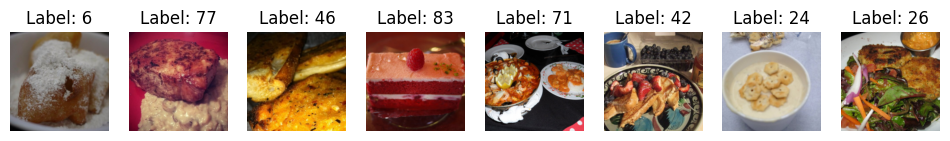

In [4]:
# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot the images
fig, axes = plt.subplots(1, len(images),figsize=(12,12))
for i, ax in enumerate(axes):
    # Convert the tensor image to numpy format
    image = images[i].numpy()
    image = image.transpose((1, 2, 0))  # Transpose to (height, width, channels)

    # Normalize the image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalized_image = (image * std) + mean
    # Display the image
    ax.imshow(normalized_image)
    ax.axis('off')
    ax.set_title(f'Label: {labels[i]}')

# Show the plot
plt.show()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)

#training
train_embeddings = []
train_labels = []

dinov2_vits14.eval()
with torch.no_grad():
  for data, labels in tqdm(trainloader):
    image_embeddings_batch = dinov2_vits14(data.to(device))

    train_embeddings.append(image_embeddings_batch.detach().cpu().numpy())
    train_labels.append(labels.detach().cpu().numpy())

#testing
test_embeddings = []
test_labels = []

dinov2_vits14.eval()
with torch.no_grad():
  for data, labels in tqdm(testloader):
    image_embeddings_batch = dinov2_vits14(data.to(device))

    test_embeddings.append(image_embeddings_batch.detach().cpu().numpy())
    test_labels.append(labels.detach().cpu().numpy())

#concatinate result
train_embeddings_f = np.vstack(train_embeddings)
train_labels_f = np.concatenate(train_labels).flatten()

test_embeddings_f = np.vstack(test_embeddings)
test_labels_f = np.concatenate(test_labels).flatten()

train_embeddings_f.shape, train_labels_f.shape, test_embeddings_f.shape, test_labels_f.shape

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 172MB/s]
100%|██████████| 3157/3157 [04:23<00:00, 11.97it/s]


((75750, 384), (75750,), (25250, 384), (25250,))

In [6]:
def evaluate_classifiers(X_train, y_train, X_test, y_test):
    # Support Vector Machine (SVM)
    svm_classifier = SVC()
    svm_classifier.fit(X_train, y_train)
    svm_predictions = svm_classifier.predict(X_test)

    # XGBoost Classifier
    xgb_classifier = XGBClassifier(tree_method='gpu_hist')
    xgb_classifier.fit(X_train, y_train)
    xgb_predictions = xgb_classifier.predict(X_test)

    # K-Nearest Neighbors (KNN) Classifier
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(X_train, y_train)
    knn_predictions = knn_classifier.predict(X_test)

    # Calculating Top-1
    top1_svm = accuracy_score(y_test, svm_predictions)
    top1_xgb = accuracy_score(y_test, xgb_predictions)
    top1_knn = accuracy_score(y_test, knn_predictions)

    # Calculating F1 Score
    f1_svm = f1_score(y_test, svm_predictions, average='weighted')
    f1_xgb = f1_score(y_test, xgb_predictions, average='weighted')
    f1_knn = f1_score(y_test, knn_predictions, average='weighted')

    return pd.DataFrame({
        'SVM': {'Top-1 Accuracy': top1_svm, 'F1 Score': f1_svm},
        'XGBoost': {'Top-1 Accuracy': top1_xgb,'F1 Score': f1_xgb},
        'KNN': {'Top-1 Accuracy': top1_knn, 'F1 Score': f1_knn}
    })

In [7]:
X_train = train_embeddings_f  # Training data features
y_train = train_labels_f  # Training data labels
X_test = test_embeddings_f   # Test data features
y_test = test_labels_f   # Test data labels

results = evaluate_classifiers(X_train, y_train, X_test, y_test)
print(results)

                     SVM   XGBoost       KNN
Top-1 Accuracy  0.894297  0.809069  0.835683
F1 Score        0.894322  0.809147  0.834141
